In [1]:
import pandas as pd

# Parquet faylını oxu
df = pd.read_parquet("train.parquet")

# İlk 5 sətirə bax
print(df.head())

                                       text  \
0      put down a resolution on the subject   
1        and he is to be backed by Mr. Will   
2     nominating any more Labour life Peers   
3       M Ps tomorrow. Mr. Michael Foot has   
4  Griffiths, M P for Manchester Exchange .   

                                               image  
0  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...  
1  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...  
2  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...  
3  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...  
4  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...  


In [2]:
print(df.columns)  # Sütun adlarını göstər
print(df.info())   # Dataset haqqında ümumi məlumat



Index(['text', 'image'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6482 entries, 0 to 6481
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    6482 non-null   object
 1   image   6482 non-null   object
dtypes: object(2)
memory usage: 101.4+ KB
None


In [18]:
print(df.image.head())

0    {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
1    {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
2    {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
3    {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
4    {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
Name: image, dtype: object


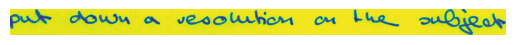

In [3]:
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt

# İlk şəkil məlumatını əldə et
image_data = df.iloc[0]['image']['bytes']  # 'bytes' açarını istifadə edin

# Bytes məlumatını bir şəkil obyektinə çevirin
image = Image.open(BytesIO(image_data))

# Şəkili göstər
plt.imshow(image)
plt.axis('off')  # Şəkilin ətrafında oxları gizlət
plt.show()

In [14]:
import pytesseract

# Tesseract-ın yolunu göstər (Windows istifadəçiləri üçün)
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# OCR ilə mətn çıxar
ocr_text = pytesseract.image_to_string(image, lang="eng", config="--psm 6").strip()

print("OCR nəticəsi:\n", ocr_text)

OCR nəticəsi:
 prle Aowu a vesolkrtiorn cou bbhe_ HQDji2 Ve


In [15]:
from Levenshtein import distance
real_text = df.iloc[0]["text"].strip()
# OCR nəticəsi və real transkripsiyanı müqayisə edək
lev_dist = distance(ocr_text.strip(), real_text.strip())

print(f"Levenshtein məsafəsi: {lev_dist}")

Levenshtein məsafəsi: 22


In [ ]:
import editdistance
import re
from rapidfuzz import fuzz, process

def clean_text(text):
    text = text.lower().strip()  # Kiçik hərflərə çevir
    text = re.sub(r'[^a-z0-9\s]', '', text)  # Xüsusi simvolları sil
    text = re.sub(r'\s+', ' ', text)  # Artıq boşluqları təmizlə
    return text

ocr_text = clean_text(ocr_text)
real_text = clean_text(df.iloc[0]["text"])

print("Təmizlənmiş OCR nəticəsi:\n", ocr_text)
print("\nReal Mətn:\n", real_text)

# Levenshtein məsafəsi hesabla
lev_dist = editdistance.eval(ocr_text, real_text)
print(f"\nLevenshtein məsafəsi: {lev_dist}")

# ---------- Səhvləri düzəltmə hissəsi ----------
# 1. Sözlük (Dictionary) bazası ilə düzəliş
word_dictionary = set(real_text.split())  # Gerçək mətndə olan unikal sözlər

def correct_word(word):
    """
    Verilən söz üçün ən uyğun düzəlişi tapır.
    """
    # Fuzzy Matching ilə söz tapma
    best_match = process.extractOne(word, word_dictionary, scorer=fuzz.partial_ratio)
    
    if best_match and best_match[1] > 80:  # Oxşarlıq 80%-dən çoxdursa, düzəlt
        return best_match[0]
    
    # Damerau-Levenshtein ilə alternativ düzəliş
    closest_word = min(word_dictionary, key=lambda x: editdistance.eval(word, x))
    if editdistance.eval(word, closest_word) <= 2:  # Səhv minimaldırsa, düzəlt
        return closest_word
    
    return word  # Əks halda olduğu kimi saxla

# OCR çıxışını düzəldək
corrected_words = [correct_word(word) for word in ocr_text.split()]
corrected_text = " ".join(corrected_words)

print("\nDüzəldilmiş OCR nəticəsi:\n", corrected_text)

# Yeni Levenshtein məsafəsini yoxlayaq
new_lev_dist = editdistance.eval(corrected_text, real_text)
print(f"\nYeni Levenshtein məsafəsi: {new_lev_dist}")

Təmizlənmiş OCR nəticəsi:
 prle aowu a vesolkrtiorn cou bbhe hqdji2 ve

Real Mətn:
 put down a resolution on the subject

Levenshtein məsafəsi: 21

Düzəldilmiş OCR nəticəsi:
 prle a a vesolkrtiorn on the hqdji2 the

Yeni Levenshtein məsafəsi: 19


In [21]:
import cv2
import numpy as np
from PIL import Image
from io import BytesIO
import pytesseract

# OCR üçün şəkli təhlil etmə funksiyası
def preprocess_image(image_data):
    # Şəkili yüklə
    image = Image.open(BytesIO(image_data))
    
    # PIL şəkilini numpy array-ə çevirmək
    image = np.array(image)

    # Şəkilin kanallarını yoxlamaq
    if len(image.shape) == 3:  # Rəngli şəkil (RGB)
        # Rəngli şəkili boz tonlara çevir
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:  # Boz tonlu şəkil
        gray = image  # Əgər şəkil artıq boz tonludursa, dəyişiklik etməyə ehtiyac yoxdur

    # Median blur tətbiq et (səs-küyün azaldılması)
    gray = cv2.medianBlur(gray, 3)

    # Tesseract üçün şəkili preprocess et
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Şəkili geri çevir
    preprocessed_image = Image.fromarray(thresh)
    return preprocessed_image

# İlk şəkil məlumatını əldə et
image_data = df.iloc[0]['image']['bytes']

# Şəkili preprocess et
preprocessed_image = preprocess_image(image_data)

# OCR ilə mətn çıxar
ocr_text = pytesseract.image_to_string(preprocessed_image, lang="eng").strip()

print("Təmizlənmiş OCR nəticəsi:\n", ocr_text)



Təmizlənmiş OCR nəticəsi:
 puke Aowun a vesoltirbor co bhe_ Die Ve


In [22]:
import editdistance
import re
from rapidfuzz import fuzz, process

def clean_text(text):
    text = text.lower().strip()  # Kiçik hərflərə çevir
    text = re.sub(r'[^a-z0-9\s]', '', text)  # Xüsusi simvolları sil
    text = re.sub(r'\s+', ' ', text)  # Artıq boşluqları təmizlə
    return text

ocr_text = clean_text(ocr_text)
real_text = clean_text(df.iloc[0]["text"])

print("Təmizlənmiş OCR nəticəsi:\n", ocr_text)
print("\nReal Mətn:\n", real_text)

# Levenshtein məsafəsi hesabla
lev_dist = editdistance.eval(ocr_text, real_text)
print(f"\nLevenshtein məsafəsi: {lev_dist}")

# ---------- Səhvləri düzəltmə hissəsi ----------
# 1. Sözlük (Dictionary) bazası ilə düzəliş
word_dictionary = set(real_text.split())  # Gerçək mətndə olan unikal sözlər

def correct_word(word):
    """
    Verilən söz üçün ən uyğun düzəlişi tapır.
    """
    # Fuzzy Matching ilə söz tapma
    best_match = process.extractOne(word, word_dictionary, scorer=fuzz.partial_ratio)
    
    if best_match and best_match[1] > 80:  # Oxşarlıq 80%-dən çoxdursa, düzəlt
        return best_match[0]
    
    # Damerau-Levenshtein ilə alternativ düzəliş
    closest_word = min(word_dictionary, key=lambda x: editdistance.eval(word, x))
    if editdistance.eval(word, closest_word) <= 2:  # Səhv minimaldırsa, düzəlt
        return closest_word
    
    return word  # Əks halda olduğu kimi saxla

# OCR çıxışını düzəldək
corrected_words = [correct_word(word) for word in ocr_text.split()]
corrected_text = " ".join(corrected_words)

print("\nDüzəldilmiş OCR nəticəsi:\n", corrected_text)

# Yeni Levenshtein məsafəsini yoxlayaq
new_lev_dist = editdistance.eval(corrected_text, real_text)
print(f"\nYeni Levenshtein məsafəsi: {new_lev_dist}")

Təmizlənmiş OCR nəticəsi:
 puke aowun a vesoltirbor co bhe die ve

Real Mətn:
 put down a resolution on the subject

Levenshtein məsafəsi: 19

Düzəldilmiş OCR nəticəsi:
 put a a vesoltirbor on the the the

Yeni Levenshtein məsafəsi: 16
